In [36]:
import gym
env = gym.make('CartPole-v1')
''' 
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. 
The system is controlled by applying a force of +1 or -1 to the cart. 
The pendulum starts upright, and the goal is to prevent it from falling over. 
A reward of +1 is provided for every timestep that the pole remains upright.
The episode ends when the pole is more than 15 degrees from vertical, or the 
cart moves more than 2.4 units from the center.
'''

# obs =  env.reset()    #returns an initial observation

In [35]:
import gym
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from collections import Counter
from copy import deepcopy

env = gym.make("CartPole-v0")
observation = env.reset()
print(observation)

[ 0.01642717  0.01088803 -0.03848342 -0.00444985]


In [12]:
class dotdict(dict):
    def __getattr__(self, name):
        return self[name]

args = dotdict({
    'lr': 0.0005,
    'dropout': 0.3,
    'epochs': 1,
    'batch_size': 64, #256,
    'pareto': 5000, # a factor to multiply action loss by to get optimal loss (5000 ish seems to work well)
    'cuda': torch.cuda.is_available(),
    'num_channels': 512,
    'goal_steps': 201, #200 is the limit for cart-pole
    'score_requirement': 65,
    'initial_games': 30000,
    'policyUpdates': 2,    #10
    'policyEpisodes': 250, #250
    'numMCTSSims': 100,
})
print(args.pareto)

5000


In [13]:
def initialExamples():
        allExamples = []
        accepted_scores = np.array([])    # just the scores that met our threshold
        init_controller = Controller()
        init_controller.nnet = None                 # so that executeEpisode doesn't try anything weird

        # --------------- ITERATE THROUGH 10000 EPISODE ------------------
        for _ in range(args.initial_games):

            exampleGame = init_controller.executeEpisode()

            # --------- SAVE EXAMPLE (EPISODE) IF (SCORE > THRESHOLD) ----------
            # Note, it does not save the score! Therefore all episodes with score > threshold
            # are treated equally (not the best way of doing this!)
            if exampleGame[0, 5] >= args.score_requirement:

                accepted_scores = np.append(accepted_scores, exampleGame[0, 5])

                if len(allExamples) == 0:
                    allExamples = exampleGame
                else:
                    allExamples = np.vstack(   (allExamples, exampleGame)   )


        # -------- PRINT STATS ------------
        avg_mean, avg_median = np.mean(accepted_scores), np.median(accepted_scores)
        print('Average accepted score: ', avg_mean)
        print('Median score for accepted scores: ', avg_median)
        print(Counter(accepted_scores))
        print(len(accepted_scores))

        return allExamples, avg_mean, avg_median

# Controller (coach) Class: PI and Episode Execution

In [37]:
class Controller():
    
    def __init__(self, nnet = None, mcts = None):
        self.nnet = nnet   # the nnet "is part of" the controller -> composition (or aggregation?.. implemented by pointer/reference in c++)
        self.mcts = mcts
                 
    def policyIteration(self):
        scores = np.array([])

        #self.nnet = Net() # don't actually need to initiate the "prev_nnet", since it is defined when we create a controller object
        init_examples, curr_mean, curr_median = initialExamples()  # Don't need to pass a model
        a_loss, v_loss, batch_acc = self.nnet.train_model(examples = init_examples)

        for i in range(args.policyUpdates):

            # ----- GENERATE A BATCH OF EPISODES BASED ON THE PREVIOUS NET----------
            exampleBatch = []
            for e in range(args.policyEpisodes):
                self.mcts = MCTS(self.nnet)     # reset search tree for each episode here (rather than the episode)
                example = self.executeEpisode() # dont need to pass self.mcts into execute episode as it is an attribute
                scores = np.append(scores, example[0, 5])

                if len(exampleBatch) == 0:
                    exampleBatch = example
                else:
                    exampleBatch = np.vstack(   (exampleBatch, example)   )


            # -------- CREATE CHALLENGER POLICY BASED ON EXAMPLES GENERATED BY PREVIOUS POLICY -------------------
            new_nnet = Net() # create a new net to train
            a_loss, v_loss, batch_acc = new_nnet.train_model(examples = exampleBatch)


            # -------- PRINT STATS ON NEW POLICY -------------
            new_mean, new_median = np.mean(scores), np.median(scores)
            print('Average accepted score: ', new_mean)
            print('Median score for accepted scores: ', new_median)
            print(Counter(scores))
            print("Current Policy: ", curr_mean, curr_median)

            # ---------- COMPARE AND UPDATE POLICIES --------------
            if new_mean >= curr_mean and new_median >= curr_median:
                self.nnet = new_nnet
                curr_mean, curr_median = new_mean, new_median
                print("Policy Updated!")
                print("New Policy: ", curr_mean, curr_median)

        return self.nnet
    
    def executeEpisode(self):
        ''' Generate and example episode of [4 x observation(t), action(t), E[return(t)]]. 
            All values are in a (n x 6) numpy array where n is the number of steps for the 
            episode to finish or the limit of 200 steps. The MCTS is reset before every 
            episode in PI.'''
                 
        score = 0
        example = np.zeros( (args.goal_steps, 6) )
        observation = env.reset(); done = False; # list of 4 elements
                 
        # --------- ITERATE UP TO 500 STEPS PER EPISODE -------------
        for t in range(args.goal_steps):

            # --------- GENERATE ACTION ------------
            # We can generate random actions or actions from a MCTS with the current policy (nnet)
            if self.nnet == None:
                action = env.action_space.sample()   # choose random action (0-left or 1-right)
            else:
                mcts_env = deepcopy(env)            #takes the current state of the env so mcts can play it out from there
                action_prob = self.mcts.getActionProb(example[t, :], done, mcts_env) # self.nnet already exists in self.mcts
                
                #the random sample is generated as if a were np.arange(a)
                #p = The probabilities associated with choosing each entry in a
                #len(p) = 2 for this -> choosing [0, 1] with probabilities action_prob associated with each
                action = np.random.choice(len(action_prob), p=action_prob) 
                              
            new_observation, reward, done, info = env.step(action)

            # --------- STORE STATE-ACTION PAIR + SCORE ------------
            example[t, 0:4] = observation[0:4]
            example[t, 4:6] = [action, score]

            observation = np.array(new_observation)
            score += reward    # +1 for every frame we haven't fallen

            if done: 
                break

        example[:, 5] = score - example[:, 5]    # Convert scores to E[return] 
        return example[0:int(score), :] # we only want to return the parts with actual values

# Monte-Carlo Tree Search Class

In [38]:
EPS = 1e-8

class MCTS():

    def __init__(self, nnet):
        self.nnet = nnet    # New policy per policy iteration
                            # (technically reinitialised each episode for PI, but it's the same until it's updated)
        self.c_puct = 0.1
        self.Qsa = {}       # stores Q values for s,a (as defined in the paper)
        self.Nsa = {}       # stores #times edge s,a was visited
        self.Ns = {}        # stores #times board s was visited
        self.Ps = {}        # stores initial policy (returned by neural net)

    def getActionProb(self, start_state_action_return, done, m_env):
        """
        This function performs numMCTSSims simulations of MCTS starting from
        the state/step that it was called on (i.e. mcts_env).
        Returns:
            probs: a policy vector where the probability of the ith action is
                   proportional to Nsa[(s,a)]**(1./temp)
        """
        # ------------ FILL OUT THE MCTS TREE -------------
        for i in range(args.numMCTSSims):
            mcts_env = deepcopy(m_env) # possibly have this outside for loop?
            self.search(start_state_action_return, done, mcts_env)
        
        # ------------- AND COUNT THE NUMBER OF TIMES EACH STATE WAS VISITED --------------
        #s = self.game.stringRepresentation(canonicalBoard)
        counts = [self.Nsa[(s,a)] if (s,a) in self.Nsa else 0 for a in range(0, 2)] # range(0, 2) = action size
        
        # ----------------- THEN NORMALISE TO A PROBABILITY -------------------
        #if temp==0:
        #    bestA = np.argmax(counts)
        #    probs = [0]*len(counts)
        #    probs[bestA]=1
        #    return probs
        
        counts = [x**(1./temp) for x in counts]
        probs = [x/float(sum(counts)) for x in counts]
        return probs


    def search(self, sqd, done, env):
        # ---------------- TERMINAL STATE ---------------
        if done == True:
            return 1

        # ------------- EXPLORING FROM A LEAF NODE ----------------------
        #check if the state has a policy from it yet, if not then its a leaf
        if s not in self.Ps:
            self.Ps[s], v = self.nnet.predict(s)

            #check if the neural net has assigned a +ve prob to any policy

            sum_Ps_s = np.sum(self.Ps[s])
            if sum_Ps_s > 0:
                self.Ps[s] /= sum_Ps_s    # renormalize
            else:
                # if they were all zero then they are equally probable: (this shouldn't usually happen)
                # NB! All valid moves may = 0 if NNet architecture is insufficient or you've get overfitting or something else.
                # If you have got dozens or hundreds of these messages you should pay attention to your NNet and/or training process.   
                print("All valid moves were masked, do workaround.")
                self.Ps[s] = self.Ps[s] + valids
                self.Ps[s] /= np.sum(self.Ps[s])

            self.Ns[s] = 0
            return v


        # ------------- GET BEST ACTION -----------------------------
        # search through the valid actions and update the UCB for all actions then update best acions
        max_u, best_a = -float("inf"), -1
        for a in range(1):
            if (s,a) in self.Qsa:
                u = self.Qsa[(s,a)] + self.cpuct*self.Ps[s][a]*np.sqrt(self.Ns[s])/(1+self.Nsa[(s,a)])
            else:
                u = self.cpuct*self.Ps[s][a]*math.sqrt(self.Ns[s] + 1e-8)     # Q = 0 ?

            if u > max_u:
                max_u = u
                best_a = a
        a = best_a


        # ----------- RECURSION TO NEXT STATE ------------------------
        sp, reward, done, info = env.step(a)
        v = self.search(sp, reward, done)


        # ------------ BACKUP Q-VALUES AND N_VISITED -----------------
        # after we reach the terminal condition then the stack unwinds and we
        # propagate up the tree backing up Q and N as we go
        if (s,a) in self.Qsa:
            self.Qsa[(s,a)] = (self.Nsa[(s,a)]*self.Qsa[(s,a)] + v)/(self.Nsa[(s,a)]+1)
            self.Nsa[(s,a)] += 1

        else:
            self.Qsa[(s,a)] = v
            self.Nsa[(s,a)] = 1

        self.Ns[s] += 1
        return v


# Define Policy (Neural Net)

In [39]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.l1 = nn.Linear(4, 128)
        self.l2 = nn.Linear(128, 256)
        self.l3 = nn.Linear(256, 128)
        self.l4 = nn.Linear(128, 32)
        
        self.dp = nn.Dropout(p = args.dropout)  # Suragnair used 0.3
        self.a1 = nn.Linear(32, 2)    # want an action vector output: [log(prob right), log(prob left)]
        self.v1 = nn.Linear(32, 32)
        self.v2 = nn.Linear(32, 1)    # Output the expected return

    def forward(self, obs):
        #in_size = x.size(0)
        x = F.relu(self.dp(self.l1(obs)))
        x = F.relu(self.dp(self.l2(x)))
        x = F.relu(self.dp(self.l3(x)))
        x = F.relu(self.dp(self.l4(x)))
        
        #x = x.view(in_size, -1)  # flatten the tensor
        a = self.a1(self.dp(x))
        action_probs = F.log_softmax(a, dim = -1)    # choose the dimension such that we get something like 
                                                     # [exp(-0.6723) +  exp(-0.7144)] = 1 for the output
        v = self.v2(self.dp(self.v1(x)))  # get a linear value for the expected return
        return action_probs, v                      
    
    
    def train_model(self, examples):
        optimizer = optim.Adam(self.parameters(), lr=args.lr)
        action_loss, value_loss, accuracy = [], [], []

        # ------------- CONVERT TO CORRECT DATA TYPE ----------------
        gpu = torch.device("cpu")
        states = torch.tensor(  examples[:, 0:4] ,  dtype = torch.float)       #reshapes into a (23002, 4) array
        target_actions = torch.tensor(  examples[:, 4], dtype = torch.long)    #reshapes into a (23002, 2) array 
        target_returns = torch.tensor(  examples[:, 5],  dtype = torch.float) 
        

        #if args.cuda:  #if we're using the GPU:
        #    states, target_actions, target_returns = states.contiguous().cuda(), target_actions.contiguous().cuda(), target_returns.contiguous().cuda()
        #states, target_pis, target_vs = Variable(states), Variable(target_actions), Variable(target_returns)
        # We should permute data before batching really. (X is a torch Variable)
        #permutation = torch.randperm(X.size()[0])
        
        for epoch in range(args.epochs):
            print('EPOCH ::: ' + str(epoch+1))
            self.train()     # set module in training mode
            batch_idx = 0
            
            for index in range(0, len(target_returns) - args.batch_size, args.batch_size):        

                # -------- GET BATCHES -----------
                #indices = permutation[i:i+batch_size]
                batch_idx = int(index / args.batch_size) + 1 #add one so stats print properly
                batch_states = states[index : index+args.batch_size] # torch.Size([64, 4])
                batch_actions = target_actions[index : index+args.batch_size] # torch.Size([64])
                batch_returns = target_returns[index: index+args.batch_size] # torch.Size([64])

                # -------------------- FEED FORWARD ---------------------- 
                pred_actions, pred_return = self.forward(batch_states) # torch.Size([64, 2]) and torch.Size([64, 1])
                batch_NumWrong = torch.abs(torch.argmax(pred_actions, dim = 1) - batch_actions).sum()
            
                a_loss = F.nll_loss(pred_actions, batch_actions, reduction = 'elementwise_mean')*args.pareto #standard is "elementwise_mean"
                
                #print(pred_actions.detach(), batch_actions.detach(), a_loss.detach())
                
                # Suragnair uses tanh for state_values, but their values are E[win] = [-1, 1] where -1 = loss
                # Here we are using the length of time that we have been "up"
                #v_loss = F.binary_cross_entropy(torch.sigmoid(pred_return[:, 0]), torch.sigmoid(batch_returns))
                v_loss = F.mse_loss(pred_return[:, 0], batch_returns, reduction = 'elementwise_mean')

                action_loss.append(a_loss);    value_loss.append(v_loss)
                tot_loss = a_loss + v_loss

                # ----------- COMPUTE GRADS AND BACKPROP ----------------
                optimizer.zero_grad()
                tot_loss.backward()
                optimizer.step()

                # --------- PRINT STATS --------------
                # Get array of predicted actions and compare with target actions to compute accuracy
                
                accuracy.append(  1 - (batch_NumWrong.detach().numpy()) / args.batch_size    ) #counts the different ones
                if batch_idx % 8 == 0:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tA-Loss: {:.4f}, V-Loss: {:.4f}\tAccuracy: {:.5f}'.format(
                            epoch+1, 
                            batch_idx * args.batch_size, 
                            states.size()[0],
                            100 * batch_idx * args.batch_size / states.size()[0], 
                            a_loss,
                            v_loss,
                            accuracy[batch_idx - 1])

                     )

        return action_loss, value_loss, accuracy # removed self?
    
    def test(self, render = False):
        self.eval()
        scores, expected_scores, choices = [], np.zeros(args.goal_steps), []

        # ------- PLAY SOME TEST GAMES ----------
        for each_game in range(10):
            env.reset()
            score, E_score = 0, []
            game_memory, prev_obs = [], []

            for _ in range(args.goal_steps):    # play up to (200) frames
                if render:
                    env.render()

                # ----- GENERATE AN ACTION -------
                if len(prev_obs)==0:    # start by taking a random action
                    action = env.action_space.sample()   

                else:                   # After that take the best predicted action by the neural net
                    x = torch.tensor(   prev_obs,   dtype = torch.float    )
                    action_prob, e_score = self.forward(x)
                    action = np.argmax(   action_prob.detach().numpy()   )
                    E_score.append(   e_score.detach().numpy()   )  # see how the game updates it expected score as we move through

                new_observation, reward, done, info = env.step(action)
                prev_obs = new_observation

                # ----- RECORD RESULTS -------
                choices.append(action)   # just so we can work out the ratio of what we're predicting

                game_memory.append([new_observation, action])
                score += reward
                if done: break

            scores.append(score)    # Record the score of each game
            padding = np.zeros(int(args.goal_steps - score + 1), dtype = int)
            E_score = np.append([np.array(E_score)], [padding])
            expected_scores = np.vstack((expected_scores, E_score))

        print('Average Score:',sum(scores)/len(scores))
        print('choice 1 (right): {:.4f}  choice 0 (left): {:.4f}'.format(choices.count(1)/len(choices),choices.count(0)/len(choices)))
        print(Counter(scores))

        x = np.linspace(1, len(expected_scores[0]), num = len(expected_scores[0]))
        plt.plot(x, expected_scores[1])
        plt.plot(x, expected_scores[3])
        plt.xlabel("Steps taken"); plt.ylabel("Expected Return (steps until failure)")
        plt.show()
        

# Run

In [40]:
test = Controller(Net())
best_model = test.policyIteration()

Average accepted score:  75.58227848101266
Median score for accepted scores:  72.0
Counter({66.0: 32, 68.0: 28, 65.0: 27, 67.0: 22, 71.0: 18, 72.0: 15, 70.0: 15, 73.0: 14, 69.0: 13, 75.0: 10, 76.0: 9, 74.0: 9, 77.0: 9, 78.0: 8, 82.0: 7, 79.0: 6, 88.0: 6, 84.0: 5, 90.0: 5, 85.0: 5, 80.0: 4, 89.0: 4, 86.0: 4, 87.0: 4, 83.0: 3, 91.0: 3, 101.0: 3, 94.0: 3, 95.0: 3, 93.0: 3, 96.0: 2, 92.0: 2, 81.0: 2, 109.0: 2, 120.0: 1, 124.0: 1, 107.0: 1, 100.0: 1, 131.0: 1, 115.0: 1, 110.0: 1, 97.0: 1, 111.0: 1, 102.0: 1, 112.0: 1})
316
EPOCH ::: 1
Train Epoch: 1 [512/23884 (2%)]	A-Loss: 3477.8572, V-Loss: 1669.7456	Accuracy: 0.48438
Train Epoch: 1 [1024/23884 (4%)]	A-Loss: 3417.7891, V-Loss: 2203.4231	Accuracy: 0.59375
Train Epoch: 1 [1536/23884 (6%)]	A-Loss: 3440.0027, V-Loss: 1435.6803	Accuracy: 0.54688
Train Epoch: 1 [2048/23884 (9%)]	A-Loss: 3398.5415, V-Loss: 1836.2518	Accuracy: 0.54688
Train Epoch: 1 [2560/23884 (11%)]	A-Loss: 3397.7146, V-Loss: 2090.0366	Accuracy: 0.56250
Train Epoch: 1 [3072/238

NameError: name 's' is not defined

Average Score: 169.6
choice 1 (right): 0.5077  choice 0 (left): 0.4923
Counter({200.0: 4, 131.0: 2, 145.0: 1, 150.0: 1, 154.0: 1, 185.0: 1})


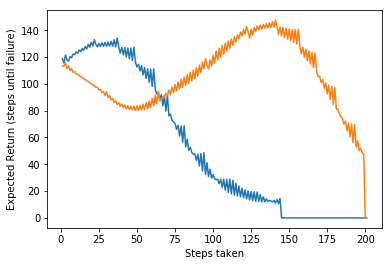

In [16]:
best_model.test(render = False)